# Analyse de la Fréquence des Données GPS
Ce notebook analyse les intervalles temporels entre les points GPS pour détecter des fréquences, des anomalies, classifier les types de déplacements et générer des visualisations utiles

## Importation des librairies

In [9]:
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import os

## Chargement des données

In [10]:
current_dir = os.getcwd()  #chemin vers le répertoire contenant le script
data_folder = os.path.abspath(os.path.join(current_dir, "..", "participant-data-semain43"))  #chemin vers le repertoire contenant le script
data_path = os.path.join(data_folder, "Cleaned_Trajectories.gpkg")  #eonstruction du chemin absolu vers le dossier contenant les données

print("Chargement des trajectoires...")
df = gpd.read_file(data_path, layer='trajectories')  #lecture du fichier GeoPackage avec GeoPandas, couche 'trajectories'
print("Colonnes disponibles :", df.columns)

Chargement des trajectoires...
Colonnes disponibles : Index(['timestamp', 'participant_virtual_id', 'lat', 'lon', 'trajectory_id',
       'speed', 'geometry'],
      dtype='object')


## Prétraitement des données

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)  #conversion de la colonne 'timestamp' au format datetime
df = df.sort_values(by=['trajectory_id', 'timestamp'])  #tri des points GPS par identifiant de trajectoire et par temps

## Analyse de la fréquence temporelle

In [12]:
df['time_diff_min'] = df.groupby('trajectory_id')['timestamp'].diff().dt.total_seconds() / 60  #calcul de temps entre deux points successifs d'un meme trajectoire
df['time_diff_min'].describe()  #affichage des statistiques descriptives sur les frequences

count    129803.000000
mean          0.057103
std           0.104794
min           0.016667
25%           0.033333
50%           0.033333
75%           0.033333
max           6.016667
Name: time_diff_min, dtype: float64

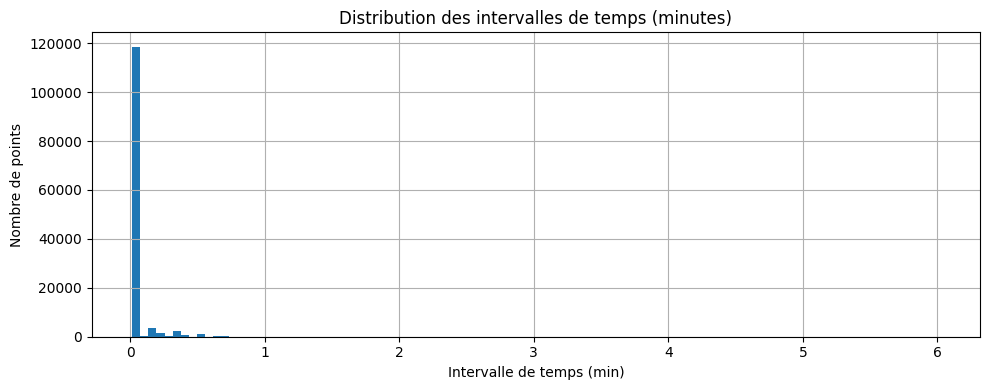

In [13]:
plt.figure(figsize=(10, 4))
df['time_diff_min'].dropna().hist(bins=100)
plt.title("Distribution des intervalles de temps (minutes)")
plt.xlabel("Intervalle de temps (min)")
plt.ylabel("Nombre de points")
plt.grid(True)
plt.tight_layout()
plt.show()

## Vérification des valeurs manquantes

In [14]:
{
    "missing_timestamps": df['timestamp'].isna().sum(),
    "missing_geometry": df['geometry'].isna().sum(),
    "missing_speed": df['speed'].isna().sum()
}

{'missing_timestamps': np.int64(0),
 'missing_geometry': np.int64(0),
 'missing_speed': np.int64(0)}

## Détection d'anomalies temporelles

In [15]:
anomalies = df[df['time_diff_min'] > 10]  #extraction des intervalles de temps superieurs a 10 min
print(f"Nombre d'intervalles > 10 minutes : {len(anomalies)}") 

Nombre d'intervalles > 10 minutes : 0


## Fréquence moyenne par participant

In [16]:
participant_freq = df.groupby('participant_virtual_id')['time_diff_min'].mean().sort_values()  #tri des points GPS par identifiant et temps
participant_freq.head()

participant_virtual_id
9999961    0.057103
Name: time_diff_min, dtype: float64

## Analyse journalière et horaire

In [17]:
df['hour'] = df['timestamp'].dt.hour  #extraction de l'heure pour chaque point GPS
df['weekday'] = df['timestamp'].dt.day_name()  # extraction du jour de la semaine
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_freq = df.groupby('hour')['time_diff_min'].mean()  #calcul de temps entre deux points successifs d'une même trajectoire
weekday_freq = df.groupby('weekday')['time_diff_min'].mean().reindex(weekday_order) 

## Visualisation de hourly_freq

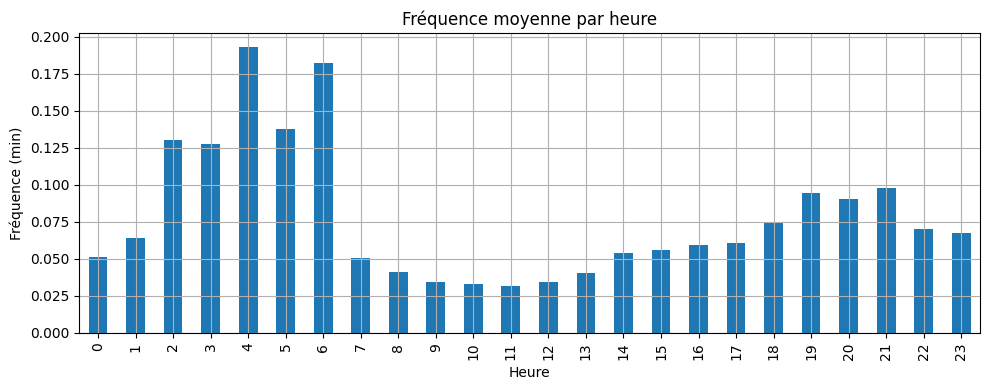

In [18]:
plt.figure(figsize=(10, 4))
hourly_freq.plot(kind='bar')
plt.title("Fréquence moyenne par heure")
plt.xlabel("Heure")
plt.ylabel("Fréquence (min)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualisation de weekday_freq

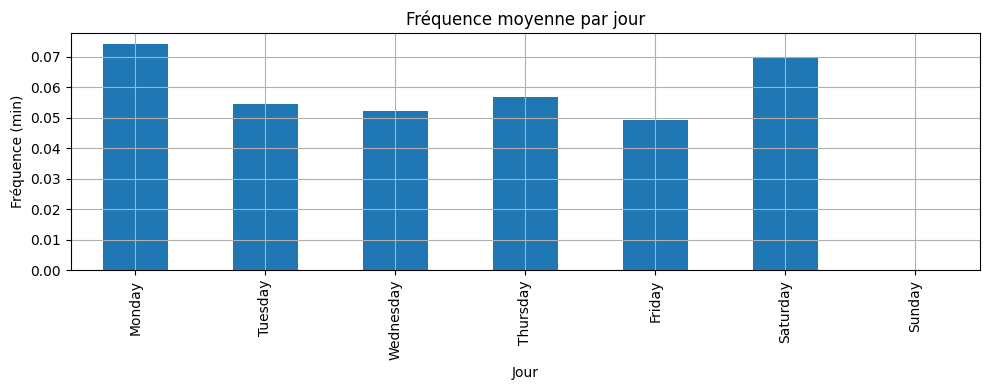

In [19]:
plt.figure(figsize=(10, 4))
weekday_freq.plot(kind='bar') 
plt.title("Fréquence moyenne par jour")
plt.xlabel("Jour")
plt.ylabel("Fréquence (min)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Estimation de la vitesse

In [ ]:
#pour chaque point d'un trajectoire on recupere la position du point precedent
df['prev_geom'] = df.groupby('trajectory_id')['geometry'].shift()

#calcule la distance entre chaque point et le point precedent si un point est absent on met NaN
df['dist_m'] = df.apply(
    lambda row: row['geometry'].distance(row['prev_geom']) if pd.notnull(row['prev_geom']) else None,
    axis=1
)

#calcul de la vitesse estimee entre deux points consecutifs (en mètres/seconde)
#la duree est en min donc on multiplie par 60 pour la convertir en sec
df['speed_est'] = df['dist_m'] / (df['time_diff_min'] * 60)

#remplacer les vitesses infinies par des valeurs manquantes (pd.NA)
df['speed_est'] = df['speed_est'].replace([float('inf'), -float('inf')], pd.NA)

df['speed_est'].describe()


count    1.298030e+05
mean     3.253102e-05
std      2.362221e-04
min      0.000000e+00
25%      0.000000e+00
50%      3.800585e-07
75%      1.715938e-05
max      6.342064e-03
Name: speed_est, dtype: float64

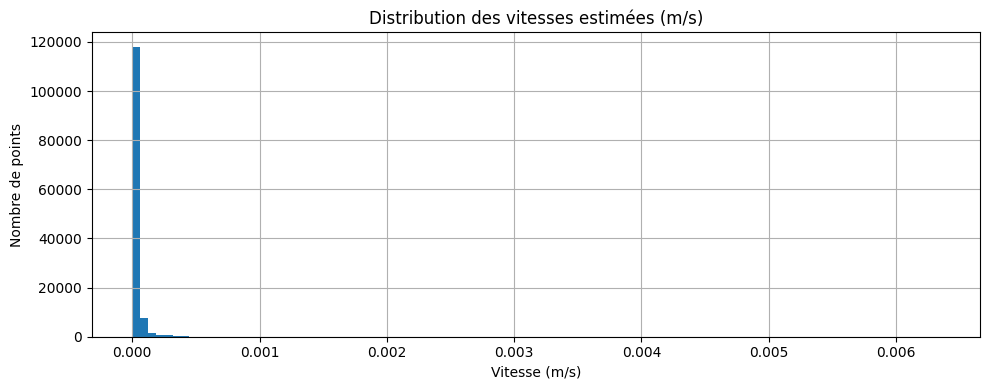

In [21]:
plt.figure(figsize=(10, 4))
df['speed_est'].dropna().clip(upper=50).hist(bins=100)
plt.title("Distribution des vitesses estimées (m/s)")
plt.xlabel("Vitesse (m/s)")
plt.ylabel("Nombre de points")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classification des types de déplacement

In [22]:
#`pd.cut` est utilisé pour creer 'movement_type' qui va contenir ('stop', 'walk', 'transport') selon la vitesse estimee

df['movement_type'] = pd.cut(df['speed_est'],                       
    bins=[-0.1, 0.1, 1.5, 50],              # Les seuils utilises pour classifier :
                                            # -0.1 à 0.1 m/s considéré comme un arrêt stop pour inclure 0 (cas d'arrêt complet)
                                            # - de 0.1 à 1.5 m/s    → considéré comme de la marche ('walk') (≈ 5.4 km/h → vitesse moyenne de marche)
                                            # - de 1.5 à 50 m/s     → considéré comme du transport motorisé ('transport')
    labels=['stop', 'walk', 'transport']   
)

#ça va nous donner par exemple combien de fois le participant etait arreté, marchait ou se deplaçait en transport
print("\n--- Répartition des types de mouvements détectés ---")
print(df['movement_type'].value_counts())



--- Répartition des types de mouvements détectés ---
movement_type
stop         129803
walk              0
transport         0
Name: count, dtype: int64


## Heatmap spatio-temporelle

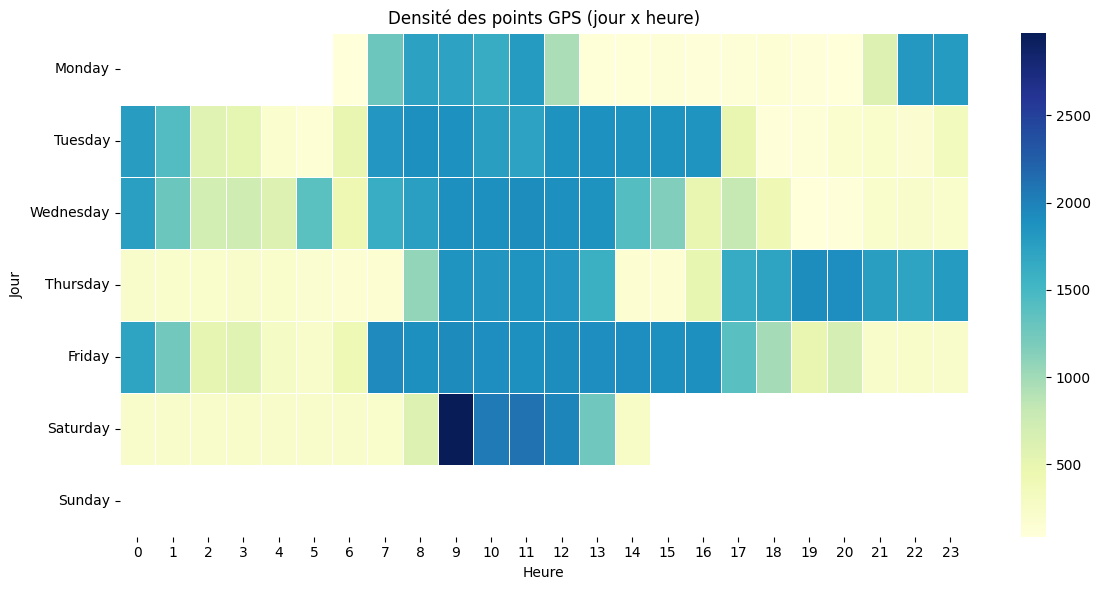

In [23]:
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack().reindex(weekday_order)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title("Densité des points GPS (jour x heure)")
plt.xlabel("Heure")
plt.ylabel("Jour")
plt.tight_layout()
plt.show()

Cette cellule analyse les points GPS enregistrés le samedi à 9h suite au pic observé dans la heatmap dessus.
Elle permet d’identifier les participants actifs (pour aprés si on va tester avec plusieurs) à ce moment et de visualiser leur trajectoire pour mieux comprendre ce comportement.

Participants actifs le samedi à 9h (classés par nombre de points) :
participant_virtual_id
9999961    2972
Name: count, dtype: int64


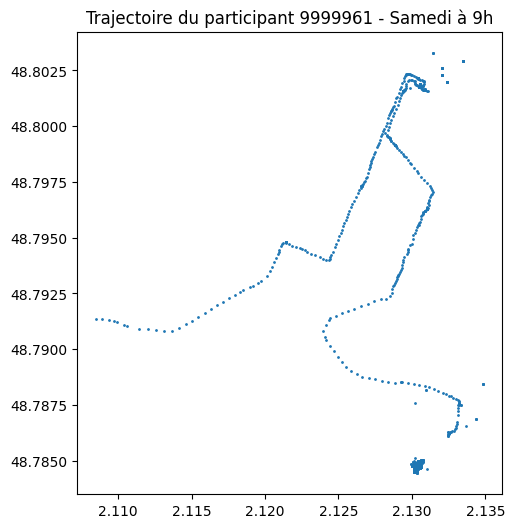

In [24]:
# Filtrer les points GPS qui ont été enregistrés un samedi à 9h
points_samedi_9h = df[(df['hour'] == 9) & (df['weekday'] == 'Saturday')]

# Afficher les participants concernés, triés par nombre de points
participant_counts = points_samedi_9h['participant_virtual_id'].value_counts()
print("Participants actifs le samedi à 9h (classés par nombre de points) :")
print(participant_counts)


# Extraire les points de ce participant à ce créneau
traj_samedi_9h = df[(df['participant_virtual_id'] == 9999961) &
                    (df['hour'] == 9) &
                    (df['weekday'] == 'Saturday')]

# Afficher une carte simple avec geopandas
traj_samedi_9h.plot(markersize=1, figsize=(8, 6), legend=True)
plt.title("Trajectoire du participant 9999961 - Samedi à 9h")
plt.show()



## Vitesse cumulée par participant

In [25]:
agg = df.groupby("participant_virtual_id").agg({  # Agrégation par participant : distance totale, durée totale, vitesse moyenne
    "dist_m": "sum",
    "time_diff_min": "sum"
})
agg["avg_speed_mps"] = agg["dist_m"] / (agg["time_diff_min"] * 60)
agg["avg_speed_kmh"] = agg["avg_speed_mps"] * 3.6
agg.sort_values("avg_speed_kmh", ascending=False).head()  # Tri des points GPS par identifiant de trajectoire et par temps croissant

,dist_m,time_diff_min,avg_speed_mps,avg_speed_kmh
participant_virtual_id,,,,
9999961,12.97464,7412.1,0.000029,0.000105


In [34]:
# ==========================================
# Rapport HTML enrichi avec images
# ==========================================

# Liste des images à intégrer (doivent déjà être générées dans le notebook)
images = [
    "frequency_histogram.png",
    "hourly_freq.png",
    "weekday_freq.png",
    "speed_distribution.png",
    "heatmap_weekday_hour.png"
]

# Création de blocs HTML <img> pour chaque image
image_blocks = ""
for img in images:
    img_path = os.path.join("..", "participant-data-semain43", img)  # Chemin relatif pour HTML
    image_blocks += f"<h3>{img.replace('_', ' ').split('.')[0].title()}</h3>"
    image_blocks += f"<img src='{img_path}' alt='{img}' width='700px' style='margin-bottom:20px;'><br>"

# Récupérer les tableaux à afficher
speed_table = avg_speed_kmh.reset_index(name='avg_speed_kmh').to_html(index=False)
freq_table = avg_time_diff.reset_index(name='avg_time_diff_min').to_html(index=False)

# Générer le contenu HTML
html_content = f"""
<h1>Rapport des Trajectoires GPS</h1>
<p><strong>Date de génération :</strong> {generation_date}</p>
<p><strong>Nombre de participants :</strong> {participant_count}</p>

<h2>📊 Vitesse moyenne par participant (km/h)</h2>
{speed_table}

<h2>🕒 Fréquence moyenne par participant (min)</h2>
{freq_table}

<h2>📈 Visualisations</h2>
{image_blocks}

<p style='font-size: small; color: gray;'>Rapport généré automatiquement à partir des données analysées.</p>
"""

# Sauvegarde dans un fichier HTML
html_path = os.path.join(report_folder, "rapport_gps_complet.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html_content)

print(f"✔️ Rapport HTML enrichi sauvegardé ici : {html_path}")


✔️ Rapport HTML enrichi sauvegardé ici : c:\Users\22302668\Desktop\CapsuleV2\participant-data-semain43\rapport_html\rapport_gps_complet.html
